WISE Meeting figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
from scipy import io
import cftime
import netCDF4 as nc
import glob
from matplotlib.animation import FuncAnimation
import pickle
from ahrs.filters import EKF
from scipy.spatial.transform import Rotation as R
%matplotlib widget

In [2]:
class microSWIFT:
    def __init__(self, mission_dataset, microSWIFT_num):
        ''' '''
        # Get all variables from microSWIFT
        microSWIFT_nc_group = mission_dataset[microSWIFT_num]
        self.time = mission_dataset['time'][:]
        self.time_datetime = cftime.num2pydate(mission_dataset['time'][:], units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
        self.sampling_freq = mission_dataset['imu_freq'][:]

        # Define all measurements as variables of the microSWIFT class
        self.ax_body = microSWIFT_nc_group['accel_x'][:]
        self.ay_body = microSWIFT_nc_group['accel_y'][:]
        self.az_body = microSWIFT_nc_group['accel_z'][:] 
        self.gyro_x = microSWIFT_nc_group['gyro_x'][:]
        self.gyro_y = microSWIFT_nc_group['gyro_y'][:]
        self.gyro_z = microSWIFT_nc_group['gyro_z'][:]
        self.mag_x = microSWIFT_nc_group['mag_x'][:]
        self.mag_y = microSWIFT_nc_group['mag_y'][:]
        self.mag_z = microSWIFT_nc_group['mag_z'][:]
        self.x = microSWIFT_nc_group['xFRF'][:]
        self.y = microSWIFT_nc_group['yFRF'][:]
        self.z = microSWIFT_nc_group['gpsElevation'][:]
        self.u = microSWIFT_nc_group['u'][:]
        self.v = microSWIFT_nc_group['v'][:]

        # Linearly interolate to fill any nan values with an interpolated value
        accel_nans = np.isnan(self.ax_body)
        self.accel_nan_inds = accel_nans
        self.ax_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ax_body[~accel_nans])
        self.ay_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ay_body[~accel_nans])
        self.az_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.az_body[~accel_nans])
        self.gyro_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_x[~accel_nans])
        self.gyro_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_y[~accel_nans])
        self.gyro_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_z[~accel_nans])
        self.mag_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_x[~accel_nans])
        self.mag_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_y[~accel_nans])
        self.mag_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_z[~accel_nans])

def transform2FRF(lat,lon):
    '''
    @edwinrainville, Originally written by J. Thomson, 1/2011

    Description: function to convert from lat & lon (decimal degrees, negative longitude) to FRF x,y (meters)
    '''

    # Define offsets
    lat_offset = 36.178039
    lon_offset = -75.749672

    # Define constants
    rotation = 19 #rotation in degress CCW from True north

    # Radius of Earth
    earth_rad = 6378.1 * 1000 # units are meters

    # correct radius for latitutde 
    radius_at_latoffset = earth_rad * np.cos(np.deg2rad(np.median(lat_offset))) 

    # Compute North-South and East-West Locations
    north = earth_rad * np.deg2rad(lat- lat_offset)
    east = radius_at_latoffset * np.deg2rad(lon_offset - lon) 

    # Rotate Coordinates by 19 degrees CCW from True north
    x = east * np.cos(np.deg2rad(rotation))   -   north * np.sin (np.deg2rad(rotation))
    x = -x # Flip x 
    y = east * np.sin(np.deg2rad(rotation))   +   north * np.cos (np.deg2rad(rotation))

    # return x and y values
    return x, y

In [3]:
# Data from 4.5 meter AWAC
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
xFRF_awac, yFRF_awac = transform2FRF(np.float64(awac_data['latitude'][:]), np.float64(awac_data['longitude'][:]))

In [4]:
def computeEta(t, accel_z, fs, low_freq_cutoff=None, high_freq_cutoff=None, order=None):
    # Define the filter if not given
    if low_freq_cutoff is None:
        low_freq_cutoff = 0.05
        high_freq_cutoff = 2
        order = 1
       
    # Define the filter
    b, a = signal.butter(order, [low_freq_cutoff, high_freq_cutoff], btype='bandpass', fs=fs)

    # Zero pad the edges to reduce edge effects
    pad_size = 500
    a_z_padded = np.zeros(accel_z.size + pad_size*2)
    a_z_padded[pad_size:-pad_size] = accel_z

    # Filter and integrate to velocity and position
    a_z = signal.filtfilt(b, a, a_z_padded)
    w_nofilt = integrate.cumulative_trapezoid(a_z, dx=1/fs, initial=0)
    w = signal.filtfilt(b, a, w_nofilt)
    z_nofilt = integrate.cumulative_trapezoid(w, dx=1/fs, initial=0)
    z = signal.filtfilt(b, a, z_nofilt)

    # Remove the edges of the time series due to the edge effects of filtering
    edge_removed = 100
    t = t[edge_removed : -edge_removed]
    a_z = a_z[pad_size + edge_removed : -(pad_size + edge_removed)]
    w = w[pad_size + edge_removed : -(pad_size + edge_removed)]
    z = z[pad_size + edge_removed : -(pad_size + edge_removed)]

    return t, a_z, w, z

def computeSpectra(z, fs):
    nperseg = 3600
    overlap = 0.75
    f, E = signal.welch(z, fs=fs, window='hann', nperseg=nperseg, noverlap=np.floor(nperseg*overlap))
    dof = np.floor(2 * z.shape[0]//nperseg)
    return f, E, dof

def bandAvgE(f, E, points_to_average):
    '''
    @ejrainville

    Split an array into sized chunks then average each chunk 
    '''
    num_sections = E.size // points_to_average
    f_chunks = np.array_split(f, num_sections)
    E_chunks = np.array_split(E, num_sections)
    f_bandavg = np.array([np.mean(chunk) for chunk in f_chunks ])
    E_bandavg = np.array([np.mean(chunk) for chunk in E_chunks ])
    return f_bandavg, E_bandavg

def processZAccel(t, accel_z, fs, low_freq_cutoff=None, high_freq_cutoff=None, order=None):
    t, a_z, w, z = computeEta(t, accel_z, fs, low_freq_cutoff, high_freq_cutoff, order)

    # Compute the spectra
    f, E, dof = computeSpectra(z, fs)
    
    # Band Average the spectra  
    points_to_average = 5
    f_bandavg, E_bandavg = bandAvgE(f, E, points_to_average)
    dof_bandavg = dof * 5

    return t, a_z, w, z, f, E, f_bandavg, E_bandavg, dof_bandavg

In [5]:
# Make a near AWAC structure 
class nearAWACData:
    def __init__(self, time_near_awac, bathy_near_awac, accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, x, y, u, v, microSWIFT_num, mission_num):
        '''
        @ ejrainville

        Initialize a data strucuture to store the data from each microSWIFT near the AWAC
        '''
        # Set all the input variables as variables in the structure
        self.time = time_near_awac
        self.bathy = bathy_near_awac
        self.a_x = accel_x
        self.a_y = accel_y
        self.a_z = accel_z
        self.gyro_x = gyro_x
        self.gyro_y = gyro_y
        self.gyro_z = gyro_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.x = x
        self.y = y
        self.u = u
        self.v = v
        self.microSWIFT_num = microSWIFT_num
        self.mission_num = mission_num

In [6]:
# Load in the pickled nearAWAC data
pik = 'nearAWAC_data.dat'
with open(pik, "rb") as f:
    nearAWAC_data = pickle.load(f)

Analysis is completed for microSWIFT 13 on Mission 18

In [7]:
# Define the dataset from the loaded in data
data_subset = nearAWAC_data[1]

# Find the 4.5 m AWAC spectrum closest to the time of this spectrum 
def nearest_ind(items, pivot):
    time_diff = np.abs([date - pivot for date in items])
    return time_diff.argmin(0)

awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
awac_time = cftime.num2pydate(awac_data['time'][:], units=awac_data['time'].units, calendar=awac_data['time'].calendar)
time_index = nearest_ind(awac_time, data_subset.time[0])
f_awac = awac_data['waveFrequency'][:]
E_awac = awac_data['waveEnergyDensity'][time_index,:]

In [8]:
# Process data with theoretical Filter - Band Pass Butterworth from 0.05 Hz - 2 Hz
t_uncorrected, a_z_uncorrected, w_uncorrected, z_uncorrected, f_uncorrected, E_uncorrected, f_bandavg_uncorrected, E_bandavg_uncorrected, dof_bandavg_uncorrected = processZAccel(data_subset.time, data_subset.a_z, fs=12, low_freq_cutoff=0.05, high_freq_cutoff=2, order=1)

# Subset the frequency and Energy Density to compare the values
f_inds_uncorrected = np.where((f_bandavg_uncorrected > 0.01) & (f_bandavg_uncorrected < 0.5))[0]
f_waves_uncorrected = np.array([f_bandavg_uncorrected[i] for i in f_inds_uncorrected])
E_waves_uncorrected = np.array([E_bandavg_uncorrected[i] for i in f_inds_uncorrected])

In [9]:
# Process data with Optimized Filter - Band Pass Butterworth from 0.069 Hz - 1.1 Hz
t_optimized, a_z_optimized, w_optimized, z_optimized, f_optimized, E_optimized, f_bandavg_optimized, E_bandavg_optimized, dof_bandavg_optimized = processZAccel(data_subset.time, data_subset.a_z, fs=12, low_freq_cutoff=0.069, high_freq_cutoff=1.1, order=1)

# Subset the frequency and Energy Density to compare the values
f_inds_optimized = np.where((f_bandavg_optimized > 0.01) & (f_bandavg_optimized < 0.5))[0]
f_waves_optimized = np.array([f_bandavg_optimized[i] for i in f_inds_optimized])
E_waves_optimized = np.array([E_bandavg_optimized[i] for i in f_inds_optimized])

In [10]:
# Process data with theoretical Filter - Band Pass Butterworth from 0.05 Hz - 2 Hz - AHRS Corrected
ahrs_data = io.loadmat('ahrs_mission18_microSWIFT_13.mat')
az_corrected = np.squeeze(ahrs_data['az_corrected'])
t_corrected, a_z_corrected, w_corrected, z_corrected, f_corrected, E_corrected, f_bandavg_corrected, E_bandavg_corrected, dof_bandavg_corrected = processZAccel(data_subset.time, az_corrected, fs=12, low_freq_cutoff=0.05, high_freq_cutoff=2, order=1)

# Subset the frequency and Energy Density to compare the values
f_inds_corrected = np.where((f_bandavg_corrected > 0.01) & (f_bandavg_corrected < 0.5))[0]
f_waves_corrected = np.array([f_bandavg_corrected[i] for i in f_inds_corrected])
E_waves_corrected = np.array([E_bandavg_corrected[i] for i in f_inds_corrected])

In [11]:
# EKF Correction of acceleration in Python
acc_data = np.array([data_subset.a_x-np.mean(data_subset.a_x), data_subset.a_y-np.mean(data_subset.a_y), data_subset.a_z-np.mean(data_subset.a_z)]).transpose()
gyr_data = np.array([data_subset.gyro_x-np.mean(data_subset.gyro_x), data_subset.gyro_y-np.mean(data_subset.gyro_y), data_subset.gyro_z-np.mean(data_subset.gyro_z)]).transpose()
mag_data = np.array([data_subset.mag_x-np.mean(data_subset.mag_x), data_subset.mag_y-np.mean(data_subset.mag_y), data_subset.mag_z-np.mean(data_subset.mag_z)]).transpose()
ekf = EKF(gyr=gyr_data, acc=acc_data, mag_data=mag_data, frequency=12, var_acc=0.0001, var_gyro=0.1, var_mag=.1, frame='NED')

# Rotate the acclerations from the computed Quaterions
r = R.from_quat(ekf.Q)
accel_rotated = r.apply(acc_data)

# Process Kalman Filtereed accelerations
t_ekfcorrected, a_z_ekfcorrected, w_ekfcorrected, z_ekfcorrected, f_ekfcorrected, E_ekfcorrected, f_bandavg_ekfcorrected, E_bandavg_ekfcorrected, dof_bandavg_ekfcorrected = processZAccel(data_subset.time, accel_rotated[:,2], fs=12, low_freq_cutoff=0.05, high_freq_cutoff=2, order=1)

# Subset the frequency and Energy Density to compare the values
f_inds_ekfcorrected = np.where((f_bandavg_ekfcorrected > 0.01) & (f_bandavg_ekfcorrected < 0.5))[0]
f_waves_ekfcorrected = np.array([f_bandavg_ekfcorrected[i] for i in f_inds_ekfcorrected])
E_waves_ekfcorrected = np.array([E_bandavg_ekfcorrected[i] for i in f_inds_ekfcorrected])


In [12]:
# AWAC Confidence interval
from scipy.stats import chi2
probability = 0.95
alpha = 1 - probability

# AWAC confidence interval
DOF_awac = 48
c_awac = chi2.ppf([1 - alpha / 2, alpha / 2], DOF_awac)
c2_awac = DOF_awac / c_awac

# uncorrected confidence interval
c_uncorrected = chi2.ppf([1 - alpha / 2, alpha / 2], dof_bandavg_uncorrected)
c2_uncorrected = dof_bandavg_uncorrected / c_uncorrected

# corrected confidence interval
c_corrected = chi2.ppf([1 - alpha / 2, alpha / 2], dof_bandavg_corrected)
c2_corrected = dof_bandavg_corrected / c_corrected

# ekfcorrected confidence interval
c_ekfcorrected = chi2.ppf([1 - alpha / 2, alpha / 2], dof_bandavg_ekfcorrected)
c2_ekfcorrected = dof_bandavg_ekfcorrected / c_ekfcorrected


Text(0, 0.5, 'Energy Density, E [m^2/Hz]')

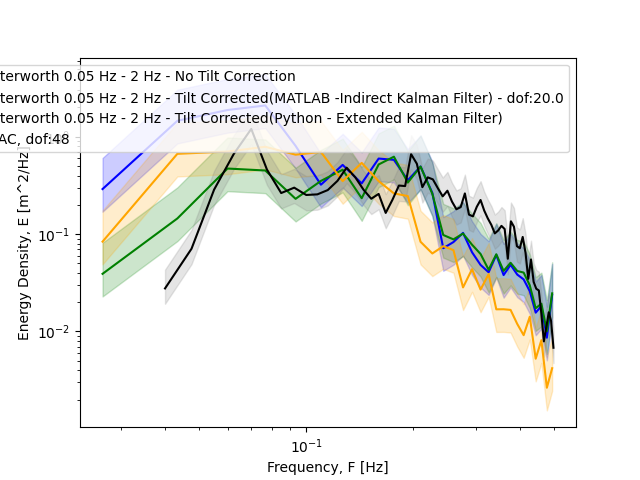

In [20]:
# Plot the spectra against the AWAC spectrum
fig_spec, ax = plt.subplots()
# Uncorrected
ax.loglog(f_waves_uncorrected, E_waves_uncorrected, label='Butterworth 0.05 Hz - 2 Hz - No Tilt Correction - dof:{}'.format(dof_bandavg_uncorrected), color='blue')
ax.fill_between(f_waves_uncorrected, E_waves_uncorrected*c2_uncorrected[0], E_waves_uncorrected*c2_uncorrected[1], color='blue', alpha=.2)

# AHRS Corrected
ax.loglog(f_waves_corrected, E_waves_corrected, label='Butterworth 0.05 Hz - 2 Hz - Tilt Corrected(MATLAB -Indirect Kalman Filter) - dof:{}'.format(dof_bandavg_corrected), color='green')
ax.fill_between(f_waves_corrected, E_waves_corrected*c2_corrected[0], E_waves_corrected*c2_corrected[1], color='green', alpha=.2)

# EKF Corrected
ax.loglog(f_waves_ekfcorrected, E_waves_ekfcorrected, label='Butterworth 0.05 Hz - 2 Hz - Tilt Corrected(Python - Extended Kalman Filter) - dof:{}'.format(dof_bandavg_corrected), color='orange')
ax.fill_between(f_waves_ekfcorrected, E_waves_ekfcorrected*c2_ekfcorrected[0], E_waves_ekfcorrected*c2_ekfcorrected[1], color='orange', alpha=.2)

# AWAC
ax.loglog(f_awac, E_awac, color='k', label='AWAC, dof:{}'.format(DOF_awac))
ax.fill_between(f_awac, E_awac*c2_awac[0], E_awac*c2_awac[1], color='gray', alpha=.2)

ax.legend()
ax.set_xlabel('Frequency, F [Hz]')
ax.set_ylabel('Energy Density, E [m^2/Hz]')

In [14]:
# Check Hs from each spectrum
Hs_awac = 4 * np.sqrt(integrate.trapz(E_awac, f_awac))
print(Hs_awac)

Hs_uncorrected = 4 * np.sqrt(integrate.trapz(E_waves_uncorrected, f_waves_uncorrected))
print(Hs_uncorrected)

Hs_optimized = 4 * np.sqrt(integrate.trapz(E_waves_optimized, f_waves_optimized))
print(Hs_optimized)

Hs_corrected = 4 * np.sqrt(integrate.trapz(E_waves_corrected, f_waves_corrected))
print(Hs_corrected)

Hs_ekfcorrected = 4 * np.sqrt(integrate.trapz(E_waves_ekfcorrected, f_waves_ekfcorrected))
print(Hs_ekfcorrected)


1.27070951461792
1.6788612885549195
1.1124250519071177
1.1995468949647063
1.2479040356347348


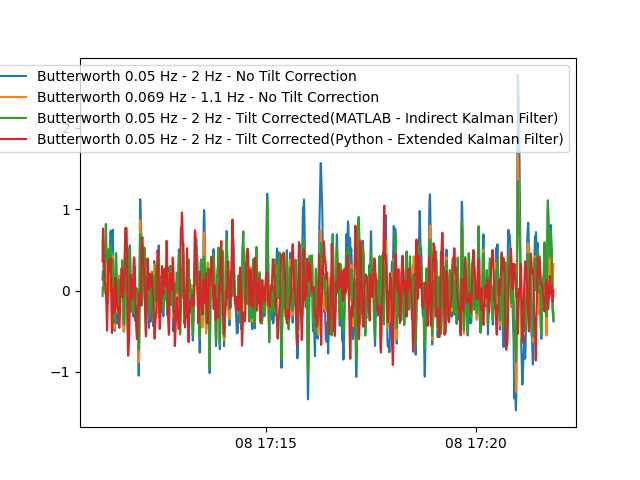

In [15]:
# Compare Time series from each method
fig_ts, ax = plt.subplots()
ax.plot(t_uncorrected, z_uncorrected, label='Butterworth 0.05 Hz - 2 Hz - No Tilt Correction')
ax.plot(t_optimized, z_optimized, label='Butterworth 0.069 Hz - 1.1 Hz - No Tilt Correction')
ax.plot(t_corrected, z_corrected, label='Butterworth 0.05 Hz - 2 Hz - Tilt Corrected(MATLAB - Indirect Kalman Filter)')
ax.plot(t_ekfcorrected, z_ekfcorrected, label='Butterworth 0.05 Hz - 2 Hz - Tilt Corrected(Python - Extended Kalman Filter)')
ax.legend()

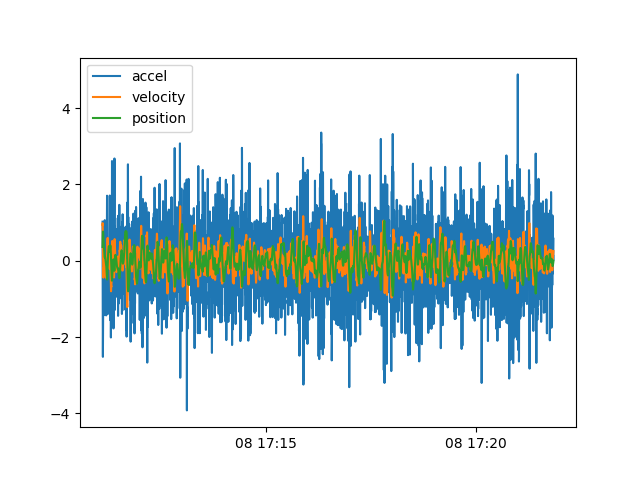

In [16]:
# Plot acceleration, velocity and position from the EKF 
fig_ekf, ax = plt.subplots()
ax.plot(t_ekfcorrected, a_z_ekfcorrected, label='accel')
ax.plot(t_ekfcorrected, w_ekfcorrected, label='velocity')
ax.plot(t_ekfcorrected, z_ekfcorrected, label='position')
ax.legend()


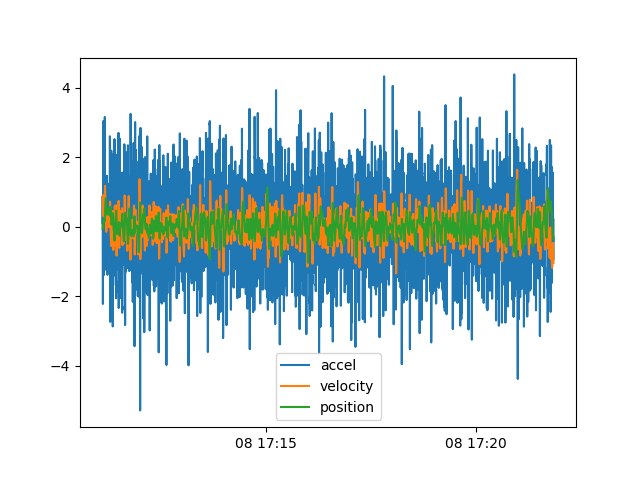

In [17]:
# Plot acceleration, velocity and position from the AHRS
fig_ahrs, ax = plt.subplots()
ax.plot(t_corrected, a_z_corrected, label='accel')
ax.plot(t_corrected, w_corrected, label='velocity')
ax.plot(t_corrected, z_corrected, label='position')
ax.legend()

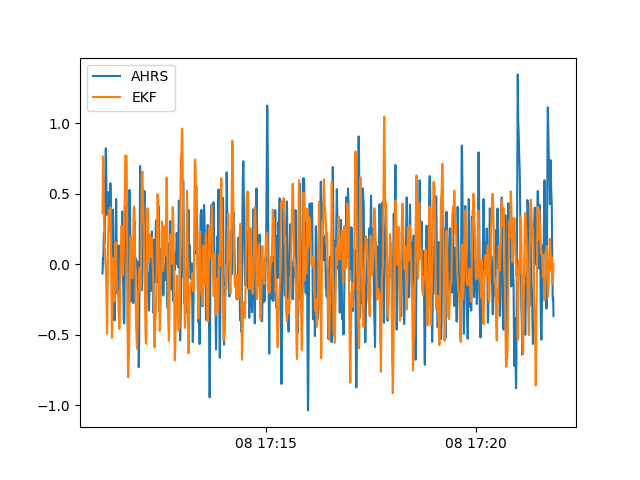

In [18]:
# Compare AHRS and EKF eta
fig_eta_comp, ax = plt.subplots()
ax.plot(t_corrected, z_corrected, label='AHRS')
ax.plot(t_ekfcorrected, z_ekfcorrected, label='EKF')
ax.legend()